Images per class: {'benign': 437, 'normal': 133, 'malignant': 210}
Original dataset size: 780
Augmented dataset size: 3724
malignant_count: 1315
normal_count: 1189
benign_count: 1220
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Output shape: (1, 3)
Class weights: {0: 1.0440145780768153, 1: 1.0174863387978141, 2: 0.9439797211660329}
Epoch 1/20
163/163 - 124s - 760ms/step - accuracy: 0.8047 - loss: 0.4941 - val_accuracy: 0.3279 - val_loss: 36.6248
Epoch 2/20
163/163 - 11s - 70ms/step - accuracy: 0.9263 - loss: 0.2070 - val_accuracy: 0.3306 - val_loss: 1.6759
Epoch 3/20
163/163 - 11s - 70ms/step - accuracy: 0.9482 - loss: 0.1304 - val_accuracy: 0.3333 - val_loss: 1.6451
Epoch 4/20
163/163 - 11s - 70ms/step - accuracy: 0.9540 - loss: 0.1379 - val_accuracy: 0.5149 - val_loss: 1.6734
Epoch 5/20
163/163 - 11s - 70ms/step - accuracy: 0.9586 - loss: 0.1164 - val_accuracy: 0.8564 - val_loss: 0.3701
Epoch 6/20
163/163 - 11s - 70ms/step - accuracy: 0.9728 - loss: 0.0723 - val_accuracy: 0.850

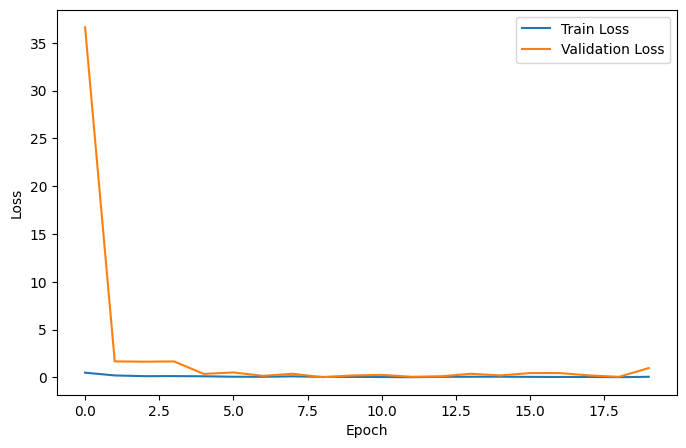

24/24 - 10s - 436ms/step - accuracy: 0.5781 - loss: 1.0551
Test Loss: 1.0551, Test Accuracy: 57.81%
24/24 - 11s - 459ms/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.47      0.99      0.64       241
      benign       0.78      0.63      0.70       243
   malignant       0.87      0.15      0.26       265

    accuracy                           0.58       749
   macro avg       0.71      0.59      0.53       749
weighted avg       0.71      0.58      0.52       749



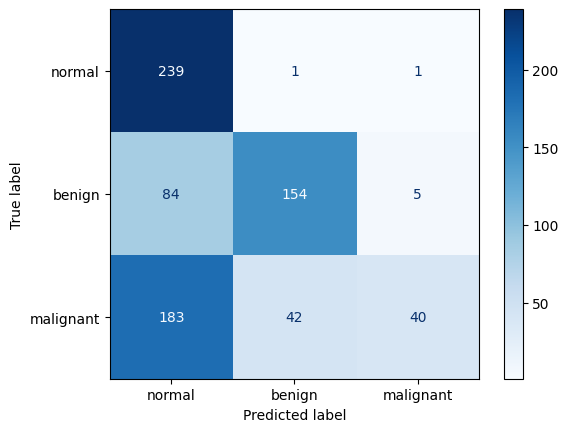

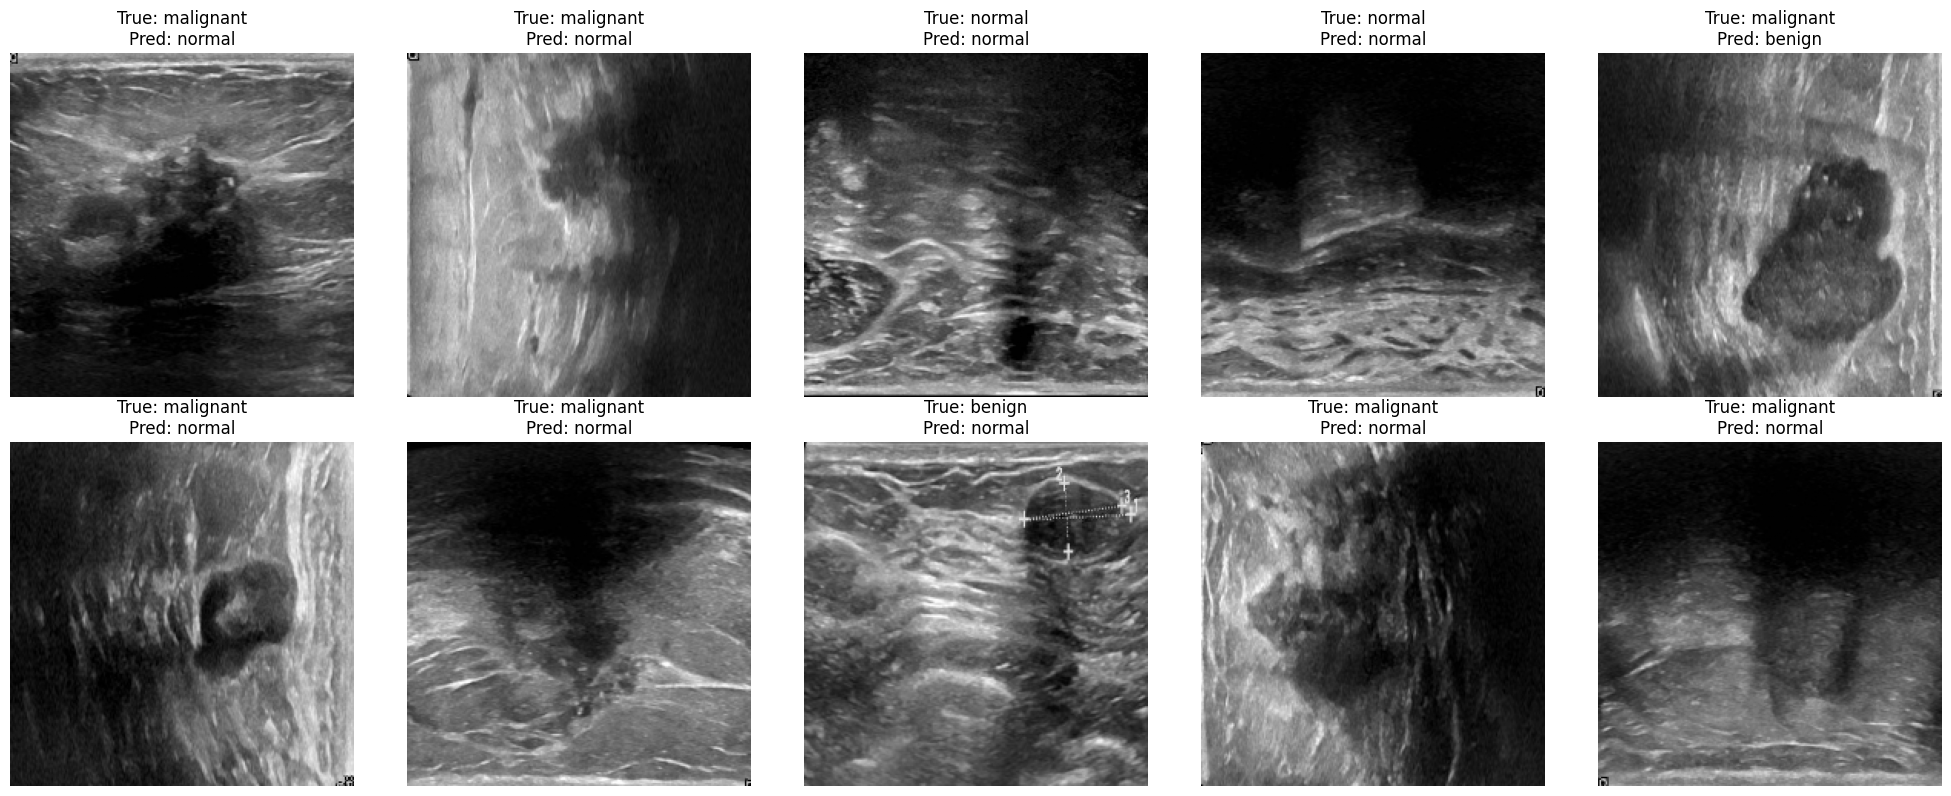

In [1]:
import numpy as np
import pandas as pd
import random
import os
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# Enable GPU memory growth
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# -------------------------
# Data Preprocessing
# -------------------------
# Path to dataset (update as needed)
path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
dir_list = [os.path.join(path, i) for i in os.listdir(path)]

def count(path):
    counts = {'benign': 0, 'normal': 0, 'malignant': 0}
    for class_name in counts:
        folder = os.path.join(path, class_name)
        counts[class_name] = sum('mask' not in img for img in os.listdir(folder))
    return counts

image_counts = count(path)
print("Images per class:", image_counts)

# For EfficientNet, using 224x224 images is common
target_size = (224, 224)
classes = ['benign', 'malignant', 'normal']

def image_processor(target_size, classes, path):
    images = []
    labels = []
    for class_name in classes:
        class_folder = os.path.join(path, class_name)
        for image_name in os.listdir(class_folder):
            if 'mask' not in image_name:
                image_path = os.path.join(class_folder, image_name)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # cv2.resize expects size as (width, height)
                image = cv2.resize(image, (target_size[1], target_size[0]))
                image_array = image / 255.0  # Normalize
                images.append(image_array)
                labels.append(class_name)
    return images, labels

images, labels = image_processor(target_size, classes, path)
img_array = np.array(images)
lab_array = np.array(labels)

# -------------------------
# Data Augmentation
# -------------------------
def augmentation(img_array, lab_array):
    """
    Applies several augmentations: rotations (clockwise, counter-clockwise, 180°)
    and flips (vertical & horizontal).
    """
    augmented_images = []
    augmented_labels = []    
    for i, img in enumerate(img_array):
        # Optionally undersample certain classes by skipping some images
        if (lab_array[i] == 'malignant') and (i % 2 != 0):
            continue
        if (lab_array[i] == 'benign') and (i % 3 != 0):
            continue
        # For the 'normal' class, apply an extra augmentation (rotate 90° counter-clockwise)
        if (lab_array[i] == 'normal') and (i % 2 != 0):
            rotated_90 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            augmented_images.append(rotated_90)
            augmented_labels.append(lab_array[i])
            continue            
        augmented_images.append(img)
        augmented_labels.append(lab_array[i])
        
        rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        augmented_images.append(rotated_90)
        augmented_labels.append(lab_array[i])
        
        rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
        augmented_images.append(rotated_180)
        augmented_labels.append(lab_array[i])
        
        flipped_0 = cv2.flip(img, 0)
        augmented_images.append(flipped_0)
        augmented_labels.append(lab_array[i])
        
        flipped_1 = cv2.flip(img, 1)
        augmented_images.append(flipped_1)
        augmented_labels.append(lab_array[i])
    
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)
    return augmented_images, augmented_labels

augmented_img_array, augmented_lab_array = augmentation(img_array, lab_array)
# Apply augmentation a second time to further expand the data
augmented_img_array, augmented_lab_array = augmentation(augmented_img_array, augmented_lab_array)

print(f"Original dataset size: {img_array.shape[0]}")
print(f"Augmented dataset size: {augmented_img_array.shape[0]}")

# Count images per class after augmentation
malignant_count = np.sum(augmented_lab_array == 'malignant')
normal_count = np.sum(augmented_lab_array == 'normal')
benign_count = np.sum(augmented_lab_array == 'benign')
print(f"malignant_count: {malignant_count}")
print(f"normal_count: {normal_count}")
print(f"benign_count: {benign_count}")

# Convert categorical labels to numerical representations
# Mapping: 'normal': 0, 'benign': 1, 'malignant': 2
class_mapper = {'normal': 0, 'benign': 1, 'malignant': 2}
augmented_lab_array = np.array([class_mapper[label] for label in augmented_lab_array])

# -------------------------
# Splitting the Data
# -------------------------
X_train, X_temp, y_train, y_temp = train_test_split(augmented_img_array, augmented_lab_array, test_size=0.3, random_state=17)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=17)

# -------------------------
# Model Definition using EfficientNetB0 (TensorFlow Keras)
# -------------------------
# Use the pretrained EfficientNetB0 architecture from Keras Applications,
# excluding the top classification layers.
base_model = tf.keras.applications.EfficientNetB0(weights="imagenet",
                                                  include_top=False,
                                                  input_shape=(target_size[0], target_size[1], 3))

# Add global pooling and a new dense layer for classification
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Optionally add a fully connected layer
# x = tf.keras.layers.Dense(1024, activation="relu")(x)
predictions = tf.keras.layers.Dense(3, activation="softmax")(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Print dummy output shape
dummy_input = np.random.random((1, target_size[0], target_size[1], 3)).astype(np.float32)
dummy_output = model(dummy_input)
print("Output shape:", dummy_output.shape)  # Expected: (1, 3)

# Compute class weights based on the augmented labels
unique_classes = np.unique(augmented_lab_array)
class_weights_array = compute_class_weight('balanced', classes=unique_classes, y=augmented_lab_array)
class_weights = dict(zip(unique_classes, class_weights_array))
print("Class weights:", class_weights)

# Compile the model using Adam optimizer (common choice for EfficientNet)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# -------------------------
# Model Training
# -------------------------
num_epochs = 20
batch_size = 16 # Reduced batch size

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=num_epochs,
                    batch_size=batch_size,
                    class_weight=class_weights,
                    verbose=2) # verbose=2 for detailed output

# Save the trained model
model.save("efficientnetb0_tf_model.h5")

# Plot training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# -------------------------
# Model Testing: Evaluation and Visualization
# -------------------------
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

# Get predictions on the test set
y_pred_prob = model.predict(X_test, batch_size=32, verbose=2)
y_pred = np.argmax(y_pred_prob, axis=1)

# Define label mapping (must match the mapping above)
label_mapping = {0: "normal", 1: "benign", 2: "malignant"}
target_names = [label_mapping[i] for i in range(3)]
report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(report)

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
cm_display.plot(cmap="Blues")
plt.show()

# -------------------------
# Random Test Image Visualization
# -------------------------
random_indices = random.sample(range(len(X_test)), 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for i, ax in enumerate(axs):
    idx = random_indices[i]
    img = X_test[idx]
    true_label = label_mapping[y_test[idx]]
    pred_label = label_mapping[y_pred[idx]]
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis("off")
plt.tight_layout()
plt.show()
